# Распознавание изображений цифр банковской карты

_Импорт библиотек_

In [2]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import os
import cv2 as cv
import random

from PIL import Image

from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

Using TensorFlow backend.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

_Загрузка данных:_

In [4]:
folder_path = os.path.dirname('~/Bank Card Number Dataset/')

original_data_path = os.path.join(folder_path, 'original/')

#test_data_path = os.path.join(folder_path, 'test')
#train_data_path = os.path.join(folder_path, 'train')

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
imgs = []

for i in range(10):
    digit = load_images_from_folder(original_data_path + str(i))
    imgs.append(digit)
    
len(imgs)

10

_Изменяем размеры изображений > 58 х 85:_

In [7]:
imgs_resized = []

for number in imgs:
    digit_resized = []
    for img in number:
        resized = cv.resize(img, dsize=(40, 60), interpolation=cv.INTER_CUBIC) #average image dimensions = 85.14011299435029 (height) x 58.110734463276835 (width)
        digit_resized.append(resized)
    imgs_resized.append(digit_resized)

_Расширяем набор данных и для каждого класса будет одинаковое количество данных:_

In [8]:
def speckle_noise(image):
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

In [9]:
def sp_noise(image):
    row, col, ch = image.shape
    
    s_vs_p = 0.3
    amount = random.uniform(0, 0.1)
    out = np.copy(image)
    
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1
    
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    
    return out

In [26]:
imgs_equal = []
max_img_count = 500

for number in imgs_resized:
    count=0
    while(count != max_img_count):
        rand_img = random.sample(number, 1)[0]
        rows, cols, _ = rand_img.shape
        matrix = cv.getRotationMatrix2D((cols,rows),random.randint(-5,5),random.uniform(0.9,1.0))
        rotated = cv.warpAffine(rand_img,matrix,(cols,rows), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)
        img_with_noise = sp_noise(rotated)
        imgs_equal.append(img_with_noise)
        
        count+=1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [27]:
def onehotencode(index, n):
    return [1.0 if i == index else 0.0 for i in range(n)]

In [28]:
labels = []
for i in range(10):
    for j in range(max_img_count):
        labels.append(onehotencode(i, 10))

_Нормализуем изображения, значения пикселей теперь будут в диапазоне от 0 до 1:_

In [29]:
data = np.asarray(imgs_equal) / 255.0
labels = np.asarray(labels)

In [30]:
random.shuffle(imgs_equal)
images = imgs_equal[0:50]

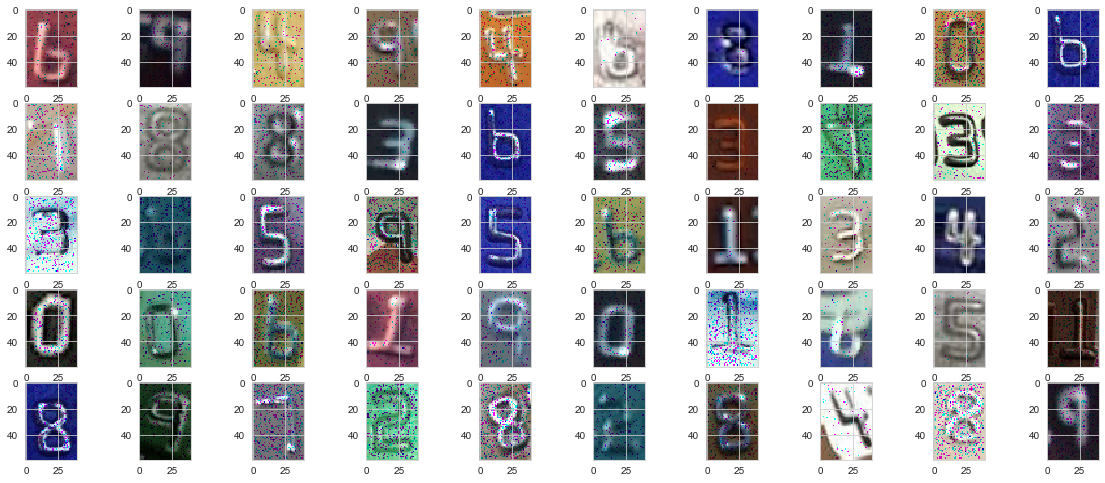

In [31]:
from PIL import Image

plt.figure(figsize=(20,10))
columns = 10
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    image = Image.fromarray(image, 'RGB')
    plt.imshow(image)

_Делим массив данных на тестовые и тренировочные данные:_

In [32]:
from sklearn.model_selection import train_test_split

SEED = 1234
np.random.seed = SEED

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, train_size=0.7)

In [33]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3500, 60, 40, 3), (1500, 60, 40, 3), (3500, 10), (1500, 10))

_Создание модели:_

In [35]:
from keras.layers.advanced_activations import PReLU

In [67]:
# Входной слой (передаем также размер изображений)
input_layer = tf.keras.layers.Input((60, 40, 3))

# Скрытые слои
hidden_layer_1 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3),  activation=tf.keras.activations.relu)(input_layer)
hidden_layer_2 = tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5),  activation=tf.keras.activations.relu)(hidden_layer_1)
hidden_layer_3 = tf.keras.layers.Conv2D(filters=10, kernel_size=(7,7),  activation=tf.keras.activations.relu)(hidden_layer_2)
hidden_layer_4 = tf.keras.layers.Flatten()(hidden_layer_3)

# Выходной слой
output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)(hidden_layer_4)

# Собираем модель
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

#
model.compile(tf.keras.optimizers.SGD(0.02), tf.keras.losses.categorical_crossentropy, metrics=['mse', 'accuracy'])

_Выводим информацию по модели:_

In [68]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 60, 40, 3)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 58, 38, 10)        280       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 54, 34, 10)        2510      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 48, 28, 10)        4910      
_________________________________________________________________
flatten_7 (Flatten)          (None, 13440)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                134410    
Total params: 142,110
Trainable params: 142,110
Non-trainable params: 0
_____________________________________________________

_Запуск модели:_

In [69]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

In [70]:
EPOCHS = 10
BATCH_SIZE = 30

history=model.fit(X_train, Y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(X_test, Y_test),
              callbacks=[EarlyStopping(patience=2)],
              verbose=1,
              shuffle=True);

Epoch 1/10
117/117 [==============================] - 26s 224ms/step - loss: 2.2302 - mse: 0.0882 - accuracy: 0.1980 - val_loss: 1.8186 - val_mse: 0.0751 - val_accuracy: 0.4400
Epoch 2/10
117/117 [==============================] - 26s 220ms/step - loss: 1.0908 - mse: 0.0473 - accuracy: 0.6729 - val_loss: 0.4633 - val_mse: 0.0214 - val_accuracy: 0.8827
Epoch 3/10
117/117 [==============================] - 23s 198ms/step - loss: 0.3549 - mse: 0.0167 - accuracy: 0.8963 - val_loss: 0.2952 - val_mse: 0.0141 - val_accuracy: 0.9147
Epoch 4/10
117/117 [==============================] - 26s 225ms/step - loss: 0.1884 - mse: 0.0090 - accuracy: 0.9449 - val_loss: 0.3165 - val_mse: 0.0131 - val_accuracy: 0.9213
Epoch 5/10
117/117 [==============================] - 27s 227ms/step - loss: 0.1358 - mse: 0.0064 - accuracy: 0.9631 - val_loss: 0.3033 - val_mse: 0.0128 - val_accuracy: 0.9240


_Сохраняем модель:_

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


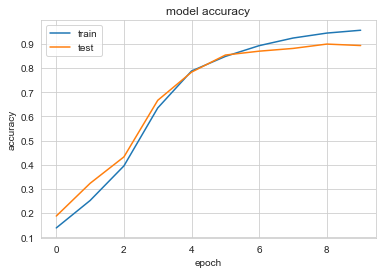

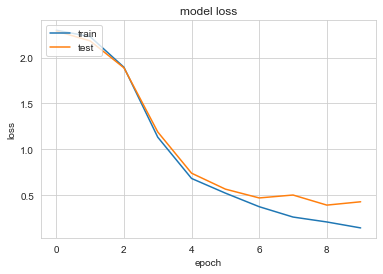

In [46]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
model.save('bank_card_model2.h5')

_Загружаем предыдущую: (если требуется)_

In [ ]:
loaded_model = tf.keras.models.load_model('bank_card_model.h5')

_Проверка на рандомных значениях из набора данных:_

In [204]:
print("a g") # a – actual images, g – guessing result

for x in range(30):
    random_index = random.randint(0, 5000)
    img = data[random_index]
    img = np.expand_dims(img, axis=0)

    guess = np.argmax(model.predict(img))
    actual = np.argmax(labels[random_index])
    print(actual, guess)

a g
8 8
5 5
2 2
2 2
3 3
1 1
5 5
9 9
8 8
5 5
8 8
2 2
6 6
3 3
6 6
3 3
6 6
2 2
3 3
6 6
8 8
0 0
2 2
1 1
5 5
7 7
1 1
2 2
5 5
9 9


_Проверка на рандомных значениях из оригинальных данных:_

In [222]:
def load_image_from_folder(folder):
    filename = random.choice(os.listdir(folder))
    
    img = cv.imread(os.path.join(folder, filename))
    resized = cv.resize(img, dsize=(40, 60), interpolation=cv.INTER_CUBIC) #average image dimensions = 85.14011299435029 (height) x 58.110734463276835 (width)

    return np.asarray(resized)/255.0

In [223]:
print("a g")

for i in range(10):
    digit = load_image_from_folder(original_data_path + str(i))
    
    img_for_test = np.expand_dims(digit, axis=0)

    guess = np.argmax(model.predict(img_for_test))
    actual = i
    print(actual, guess)

a g
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 3


In [ ]:
print(history.history.keys())

In [ ]:
print(history.history)